In [100]:
import pandas as pd
import pickle
import networkx as nx
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3 import A2C

In [33]:
a = pd.read_parquet("./sunt/2024-03-01/viagens/viagens.parquet",engine='pyarrow')
pd.options.display.max_columns = None
a["paradas"][29090]

array([{'dataHoraEntradaPonto': '01/03/2024 23:17:40', 'dataHoraPrevistaEntradaPonto': '01/03/2024 23:18:28', 'dataHoraPrevistaSaidaPonto': None, 'dataHoraSaidaPonto': '01/03/2024 23:17:40', 'idPonto': 20},
       {'dataHoraEntradaPonto': '01/03/2024 23:18:14', 'dataHoraPrevistaEntradaPonto': '01/03/2024 23:19:02', 'dataHoraPrevistaSaidaPonto': None, 'dataHoraSaidaPonto': '01/03/2024 23:18:25', 'idPonto': 30},
       {'dataHoraEntradaPonto': '01/03/2024 23:19:05', 'dataHoraPrevistaEntradaPonto': '01/03/2024 23:19:35', 'dataHoraPrevistaSaidaPonto': None, 'dataHoraSaidaPonto': '01/03/2024 23:19:15', 'idPonto': 21},
       {'dataHoraEntradaPonto': '01/03/2024 23:20:06', 'dataHoraPrevistaEntradaPonto': '01/03/2024 23:21:29', 'dataHoraPrevistaSaidaPonto': None, 'dataHoraSaidaPonto': '01/03/2024 23:21:06', 'idPonto': 22},
       {'dataHoraEntradaPonto': '01/03/2024 23:22:17', 'dataHoraPrevistaEntradaPonto': '01/03/2024 23:23:00', 'dataHoraPrevistaSaidaPonto': None, 'dataHoraSaidaPonto': '01/

In [30]:
b = pd.read_csv("./sunt/2024-03-01/output/sobe_desce_01-03-2024_esp.csv")
b

C:\Users\Fernando\AppData\Local\Temp\ipykernel_16468\231557939.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  b = pd.read_csv("./sunt/2024-03-01/output/sobe_desce_01-03-2024_esp.csv")


,route_short_name,register_code,direction_id,pt_sequence,stop_id,vehicle,trip_number,trip_id,start_trip,end_trip,stop_time,n-boardings,lag_loading,n-alighting,balance,loading
0,1141,12730,I,1,44028970,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,2024-03-01 06:07:50,8.0,0.000000,0.0,0.000000,8.000000
1,1141,12730,I,2,44783401,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,2024-03-01 06:07:52,5.0,8.000000,0.0,8.000000,13.000000
2,1141,12730,I,3,44783402,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,2024-03-01 06:08:49,5.0,13.000000,0.0,13.000000,18.000000
3,1141,12730,I,4,45833865,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,2024-03-01 06:10:12,6.0,18.000000,0.0,18.000000,24.000000
4,1141,12730,I,5,44739642,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,2024-03-01 06:11:26,6.0,24.000000,0.0,24.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739261,933,53413,V,72,45833241,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,2024-03-01 20:47:29,0.0,9.260825,0.0,9.260825,9.260825
739262,933,53413,V,73,44784172,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,2024-03-01 20:49:43,0.0,9.260825,0.0,9.260825,9.260825
739263,933,53413,V,74,44784207,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,2024-03-01 20:50:08,0.0,9.260825,0.0,9.260825,9.260825
739264,933,53413,V,75,44783418,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,2024-03-01 20:50:39,0.0,9.260825,0.0,9.260825,9.260825


In [9]:
b.sort_values(by=["n-boardings"])

,route_short_name,register_code,direction_id,pt_sequence,stop_id,vehicle,trip_number,trip_id,start_trip,end_trip,stop_time,n-boardings,lag_loading,n-alighting,balance,loading
369632,1436,12846,I,43,44782577,21140,1,21140_1436_1,2024-03-01 04:48:34,2024-03-01 06:11:11,2024-03-01 05:43:05,0.0,53.528224,2.277797,51.250427,51.250427
439956,1637,43675,I,12,44782382,30080,1,30080_1637_1,2024-03-01 06:45:28,2024-03-01 08:34:28,2024-03-01 07:01:47,0.0,32.755853,1.259840,31.496012,31.496012
439954,1637,43675,I,10,43768546,30080,1,30080_1637_1,2024-03-01 06:45:28,2024-03-01 08:34:28,2024-03-01 06:59:59,0.0,33.026087,1.270234,31.755853,31.755853
439945,1637,43675,I,1,43786925,30080,1,30080_1637_1,2024-03-01 06:45:28,2024-03-01 08:34:28,2024-03-01 06:45:28,0.0,0.000000,0.000000,0.000000,0.000000
439944,355,62003,V,3,44042532,31096,24,31096_0355_24,2024-03-02 00:32:51,2024-03-02 00:34:49,2024-03-02 00:34:49,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612053,137,50785,I,1,43768720,21123,7,21123_0137_7,2024-03-01 08:21:29,2024-03-01 08:45:08,2024-03-01 08:21:29,176.0,0.000000,0.000000,0.000000,176.000000
613711,137,50785,I,1,43768720,21132,3,21132_0137_3,2024-03-01 07:03:30,2024-03-01 07:26:54,2024-03-01 07:03:30,214.0,0.000000,0.000000,0.000000,214.000000
607414,137,50785,I,1,43768720,21129,3,21129_0137_3,2024-03-01 06:45:22,2024-03-01 07:09:58,2024-03-01 06:45:22,239.0,0.000000,0.000000,0.000000,239.000000
612928,137,50785,I,1,43768720,21126,3,21126_0137_3,2024-03-01 07:51:05,2024-03-01 08:14:09,2024-03-01 07:51:05,241.0,0.000000,0.000000,0.000000,241.000000


In [2]:
with open('./sunt/graph_designer/graph_gtfs.gpickle', 'rb') as f:
    G = pickle.load(f)
G

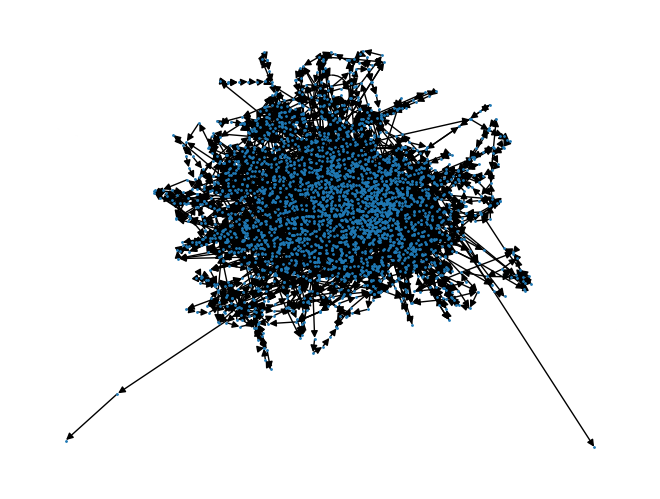

In [12]:
nx.draw(G, with_labels=False, node_size=1)

In [73]:
print(list(G.nodes))
map = {}
for node in G.nodes:
    map[node] = int(node)
G = nx.relabel_nodes(G, map)
print(list(G.nodes))

[100009577, 345936831, 100722777, 100722778, 44782645, 45833440, 66771046, 45833436, 101214305, 44783222, 101269104, 44782718, 102324560, 153081312, 103551893, 44164978, 45833280, 104226128, 185591476, 204343073, 104226129, 104226133, 104226130, 43768405, 104226131, 185591475, 104226132, 104226135, 104226134, 105082910, 44784617, 106367555, 106367556, 106367557, 45834147, 45834150, 106394017, 106394018, 106394021, 106394019, 193509115, 106394020, 193509116, 107013409, 44165481, 107018068, 44423222, 107018201, 44782773, 107018906, 193549866, 107023635, 202057097, 277469509, 107679327, 45834170, 107915276, 44093683, 109327111, 44783270, 44784580, 45834100, 110005341, 44782995, 110438500, 110952763, 110952736, 110952766, 44784316, 45833801, 110953996, 313101810, 111373595, 44782577, 111530447, 44783944, 117165992, 44784132, 117165993, 117165994, 117513349, 44783142, 117513350, 44783526, 45833212, 117558839, 45833273, 117558840, 117979075, 44782393, 118681574, 44164964, 120548519, 13259470

In [4]:
print(len(G.edges))
print(G.edges)

4526
[('100009577', '345936831'), ('345936831', '45833961'), ('100722777', '100722778'), ('100722777', '44782645'), ('100722777', '45833440'), ('100722777', '66771046'), ('100722778', '45833436'), ('44782645', '303336341'), ('44782645', '45833092'), ('44782645', '45833743'), ('44782645', '45834367'), ('45833440', '44782645'), ('45833440', '66771046'), ('66771046', '44782643'), ('45833436', '45833434'), ('101214305', '44783222'), ('44783222', '44784277'), ('101269104', '44782718'), ('44782718', '44783707'), ('102324560', '153081312'), ('153081312', '82414041'), ('103551893', '44164978'), ('103551893', '45833280'), ('44164978', '193482013'), ('44164978', '45833280'), ('45833280', '44783382'), ('104226128', '185591476'), ('104226128', '204343073'), ('185591476', '104226130'), ('204343073', '43768405'), ('104226129', '104226133'), ('104226133', '104226131'), ('104226133', '104226134'), ('104226130', '43768405'), ('43768405', '44387666'), ('43768405', '44783519'), ('104226131', '185591475')

In [104]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, network: nx.Graph, max_steps: int = 50):
        self.network = network  # The size of the square grid
        self.count = 0
        self.position = list(self.network.nodes)[random.randint(0, self.network.number_of_nodes()-1)]
        self.n = self.network.number_of_nodes()
        self.max_steps = max_steps

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(9)
        self.observation_space = gym.spaces.Box(low=0, high=np.array([self.n]), shape=(1,), dtype=np.int32)

    def reset(self,seed=None):
        super().reset(seed=seed)
        self.position = list(self.network.nodes)[random.randint(0, self.network.number_of_nodes()-1)]
        self.count = 0

        obs = self.position
        return obs, {}
    
    def step(self,action):
        possible_actions = list(self.network.neighbors(self.position))
        #print(possible_actions)
        if action < len(possible_actions):
            self.position = possible_actions[action]
            reward = possible_actions[action]// 10000
        else:
            reward = -100000

        self.count += 1
        terminated = self.count >= self.max_steps
        obs = self.position
        return obs, reward, terminated, False, {"count" : self.count}




In [105]:
env = GridWorldEnv(G)

In [109]:
def run_q(episodes, env, is_training=True):

    if(is_training):
        q = np.zeros((env.n, env.action_space.n))
    else:
        f = open('q.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    # Hyperparameters
    learning_rate_a = 0.9   
    discount_factor_g = 0.9 
    epsilon = 1             

    # Array to keep track of the number of steps per episode for the robot to find the target.
    # We know that the robot will inevitably find the target, so the reward is always obtained,
    # so we want to know if the robot is reaching the target efficiently.
    reward_per_episode = np.zeros(episodes)

    dict = {}
    seen_nodes = 0
    for i in range(episodes):
        state = env.reset()[0]

        if state not in dict:
            dict[state] = seen_nodes
            seen_nodes += 1

        terminated = False

        while(not terminated):

            if is_training and random.random() < epsilon:
                action = env.action_space.sample()
            else:                
                q_state_idx = (state) 

                action = np.argmax(q[dict[q_state_idx]])
            
            new_state,reward,terminated,_,_ = env.step(action)
            if new_state not in dict:
                dict[new_state] = seen_nodes
                seen_nodes += 1

            q_state_action_idx = (dict[state],action)

            q_new_state_idx = (dict[new_state])

            if is_training:
                q[q_state_action_idx] = q[q_state_action_idx] + learning_rate_a * (
                        reward + discount_factor_g * np.max(q[q_new_state_idx]) - q[q_state_action_idx]
                )

            state = new_state

            reward_per_episode[i] += reward

        epsilon = max(epsilon - 1/episodes, 0)

    env.close()

    sum_reward = np.zeros(episodes)
    for t in range(episodes):
        sum_reward[t] = np.mean(reward_per_episode[max(0, t-100):(t+1)]) 
    plt.plot(sum_reward)
    plt.savefig('q.png')

    if is_training:
        # Save Q Table
        f = open("q.pkl","wb")
        pickle.dump(q, f)
        f.close()
    return reward_per_episode


[-3955031. -3849258. -4186677. ...   676509.  1225638.  1259899.]


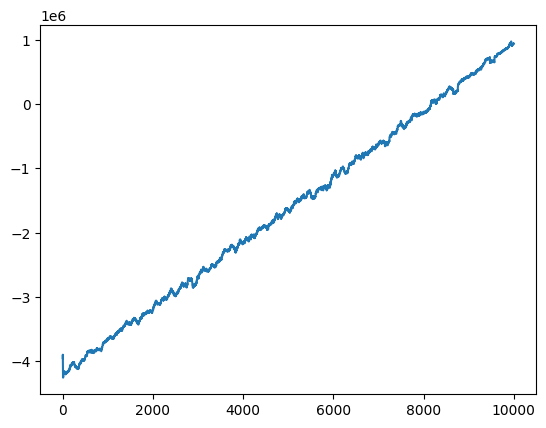

In [111]:
print(run_q(10000, env, is_training=True))

[673961.]


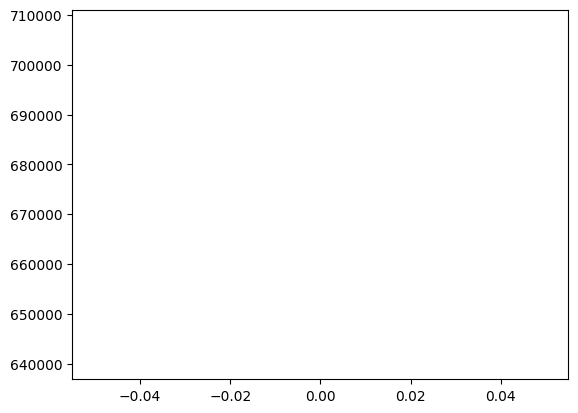

In [115]:
print(run_q(1, env, is_training=False))

[673961.]


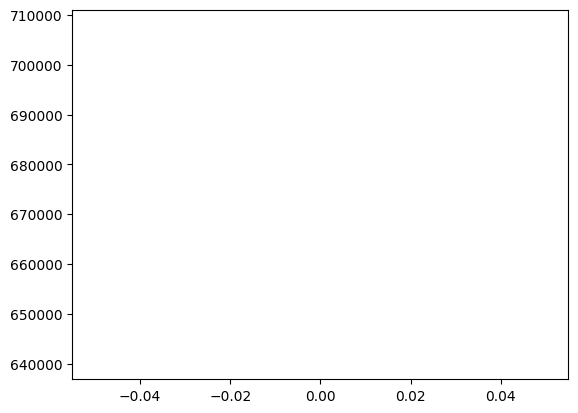

In [ ]:
def train_sb3():
    # Where to store trained model and logs
    model_dir = "models"
    log_dir = "logs"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    env = gym.make('warehouse-robot-v0')

    # Use Advantage Actor Critic (A2C) algorithm.
    # Use MlpPolicy for observation space 1D vector.
    model = A2C('MlpPolicy', env, verbose=1, device='cuda', tensorboard_log=log_dir)
   
    # This loop will keep training until you stop it with Ctr-C.
    # Start another cmd prompt and launch Tensorboard: tensorboard --logdir logs
    # Once Tensorboard is loaded, it will print a URL. Follow the URL to see the status of the training.
    # Stop the training when you're satisfied with the status.
    TIMESTEPS = 1000
    iters = 0
    while True:
        iters += 1

        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False) # train
        model.save(f"{model_dir}/a2c_{TIMESTEPS*iters}") # Save a trained model every TIMESTEPS